In [1]:
from setup import *

# 1. Simulate FFPE samples using PCAWG mutation profiles

## 1.1 Read FFPE signatures

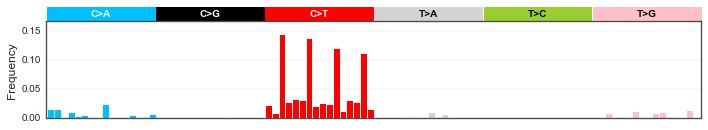

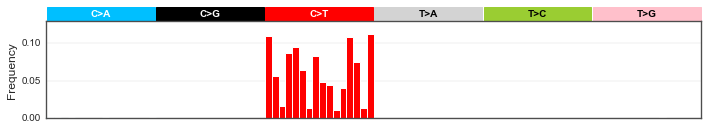

In [2]:
SBS96_plot(ffpe_sig_repaired, norm = True)
SBS96_plot(ffpe_sig_unrepaired, norm = True)

## 1.2 Read PCAWG mutational profiles

In [3]:
profiles = pd.read_csv("./Data/WGS_PCAWG.96.csv")
profile_values = profiles.iloc[:,2:]
profiles.head(2)

,Mutation type,Trinucleotide,Biliary-AdenoCA::SP117655,Biliary-AdenoCA::SP117556,Biliary-AdenoCA::SP117627,Biliary-AdenoCA::SP117775,Biliary-AdenoCA::SP117332,Biliary-AdenoCA::SP117712,Biliary-AdenoCA::SP117017,Biliary-AdenoCA::SP117031,...,Uterus-AdenoCA::SP94540,Uterus-AdenoCA::SP95222,Uterus-AdenoCA::SP89389,Uterus-AdenoCA::SP90503,Uterus-AdenoCA::SP92460,Uterus-AdenoCA::SP92931,Uterus-AdenoCA::SP91265,Uterus-AdenoCA::SP89909,Uterus-AdenoCA::SP90629,Uterus-AdenoCA::SP95550
0,C>A,ACA,269,114,105,217,52,192,54,196,...,117,233,94,114,257,139,404,97,250,170
1,C>A,ACC,148,56,71,123,36,139,54,102,...,90,167,59,64,268,75,255,78,188,137


## 1.3 Simulate PCAWG FFPE samples

In [4]:
def simulation(sample_indvidual, ffpe_sig, ffpe_load):
    v = sample_indvidual + poisson.rvs(ffpe_sig * ffpe_load)
    return (v)

simulated_df_unrepaired_10_4, simulated_df_repaired_10_4 = pd.DataFrame(), pd.DataFrame()
for i, col in enumerate(profile_values.columns):
    npr.seed(i + 1)
    sample = profiles[col].to_numpy()
    simulated_df_unrepaired_10_4 [col] = simulation(sample_indvidual = sample, 
                                                    ffpe_sig = ffpe_sig_unrepaired, 
                                                    ffpe_load = 10**4)
    
    simulated_df_repaired_10_4 [col] = simulation(sample_indvidual = sample, 
                                                    ffpe_sig = ffpe_sig_repaired, 
                                                    ffpe_load = 10**4)
## write the simulated samples to Data folder
simulated_df_unrepaired_10_4.to_csv ("./Data/simulated_PCAWG_FFPE_unrepaired.csv", index = False)
simulated_df_repaired_10_4.to_csv ("./Data/simulated_PCAWG_FFPE_repaired.csv", index = False)

# 2. Correction of FFPE noise in the simulated samples
## 2.1 One example of correcting FFPE profile

We performed the same cleaning process for all simulated samples on the HPC (Apoctria, Queen Mary University of Longon) due to the long running time on local PC. Here we show an example on how it works and also correction result for one sample from colorectal cancer.

In [5]:
example_sample = "ColoRect-AdenoCA::SP21528"
cancer_type, sample_id =  example_sample.split("::")
biological_profile = profile_values[example_sample].to_numpy()
ffpe_profile = simulated_df_unrepaired_10_4[example_sample]

corrected_profile, corrected_profiles_df = correct_FFPE_profile(V = ffpe_profile.to_numpy(), 
                                                                W1 = ffpe_sig_unrepaired,
                                                                sample_id= sample_id)

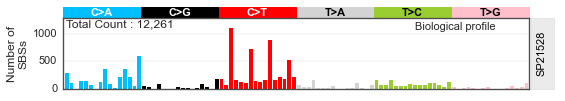

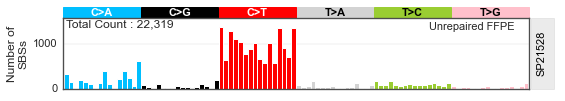

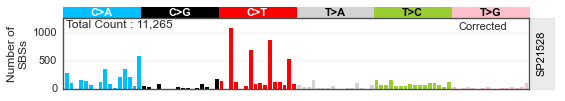

In [6]:
## plot all profiles
SBS96_plot(biological_profile, label = f"{sample_id}\n", 
           name = "Biological profile", file = "./Figures/Fig2a_1.pdf",
           height = 1.6, width = 8, s = 11)

SBS96_plot(ffpe_profile, label = f"{sample_id}\n", name = "Unrepaired FFPE",
           file = "./Figures/Fig2a_2.pdf",
           height = 1.6, width = 8, s = 11)

SBS96_plot(corrected_profile, label = f"{sample_id}\n", name = "Corrected",
           file = "./Figures/Fig2a_3.pdf",
           height = 1.6, width = 8, s = 11)

In [7]:
C2T_ind = ["C>T" == t for t in profiles['Mutation type']]
n_channel = np.sum(C2T_ind)
cs = cosine_similarity(biological_profile[C2T_ind].reshape(1,n_channel), 
                               corrected_profile[C2T_ind].reshape(1,n_channel))[0][0]
print ("Compare corrected profile to biological profile(96c):", cs)

Compare corrected profile to biological profile(96c): 0.988113187476812


## 2.2 Correction results for all simulated FFPE samples

**NOTE:** The correction process is the same for all PCAWG samples as shown in the above example. To save time, we did parallel-run in our local HPC cluster. Here, we will read the collected results for all samples from the cluster.

### 2.2.1 Comparing correction accuracy using all mutations versus using C>T mutations

Because our FFPE siganture mostly distributed in C>T channels, therefore our correction method will subtracting noise mutaion counts from C>T mutation channels. The other non C>T mutation channels would remain at a very similar level.  Therefore, using all 96-channel will increase the accuracy, but this increase was not due to our correction method. So we focus on accuracy calculation only on C>T channels.

In [8]:
## unrepaired FFPE:
unrepaired_profiles_corrected = pd.read_csv("./Data/unrepaired_profiles_corrected.csv", sep ="\t")

## Repaired FFPEs:
repaired_profiles_corrected = pd.read_csv("./Data/repaired_profiles_corrected.csv", sep ="\t")

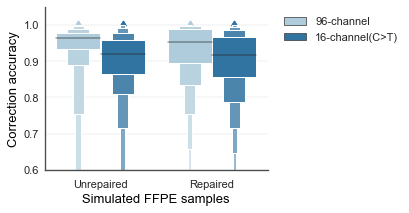

In [9]:
## 96-channel
C2T_ind = ["C>T" == t for t in profiles['Mutation type']]


n_channel = unrepaired_profiles_corrected.shape[0]
## unrepaired
accuracy = [cosine_similarity(profile_values[col].to_numpy().reshape(1,n_channel), 
                        unrepaired_profiles_corrected[col].to_numpy().reshape(1,n_channel))[0][0] 
                        for col in unrepaired_profiles_corrected.columns[1:]]
group = ["Unrepaired"] * len(unrepaired_profiles_corrected.columns[1:])

## repaired
accuracy += [cosine_similarity(profile_values[col].to_numpy().reshape(1,n_channel), 
                        repaired_profiles_corrected[col].to_numpy().reshape(1,n_channel))[0][0] 
                        for col in unrepaired_profiles_corrected.columns[1:]]

group += ["Repaired"] * len(unrepaired_profiles_corrected.columns[1:])
labels = ["96-channel"] * len(unrepaired_profiles_corrected.columns[1:]) * 2

## 16-channel
n_channel = np.sum(C2T_ind)
## unrepaired
accuracy += [cosine_similarity(profile_values[col][C2T_ind].to_numpy().reshape(1,n_channel), 
                        unrepaired_profiles_corrected[col][C2T_ind].to_numpy().reshape(1,n_channel))[0][0] 
                        for col in unrepaired_profiles_corrected.columns[1:]]
group += ["Unrepaired"] * len(unrepaired_profiles_corrected.columns[1:])

## repaired
accuracy += [cosine_similarity(profile_values[col][C2T_ind].to_numpy().reshape(1,n_channel), 
                        repaired_profiles_corrected[col][C2T_ind].to_numpy().reshape(1,n_channel))[0][0] 
                        for col in repaired_profiles_corrected.columns[1:]]
group += ["Repaired"] * len(unrepaired_profiles_corrected.columns[1:])
labels += ["16-channel(C>T)"] * len(unrepaired_profiles_corrected.columns[1:]) * 2

## for plotting
f, ax = plt.subplots (figsize = (4,3))
df_acc_diff_channel = pd.DataFrame()
accuracy_changes = pd.DataFrame({"Group": group,
                                 "Label": labels,
                                 "Accuracy":accuracy})

sns.boxenplot(x = "Group", y = "Accuracy", data = accuracy_changes, hue = "Label", 
                       palette= sns.color_palette("Paired")[0:2], ax = ax)
ax.set_ylim (0.6,1.05)
#ax.set_xticklabels(['Before\ncorrection','After\ncorrection'])
ax.set_xlabel ("Simulated FFPE samples", color = "black", size = 13)
ax.set_ylabel("Correction accuracy", size = 13, color = "black")
plt.legend(bbox_to_anchor=(1.03, 1),frameon = False)
sns.despine()
plt.savefig ("./Figures/SFig6.pdf", bbox_inches = "tight", dpi = 300)
plt.show()

### 2.2.2 Collecting correction results for unrepaired FFPEs

In [10]:
## collecting accuracy
C2T_ind = ["C>T" in t for t in profiles['Mutation type']]
n_channel = np.sum(C2T_ind)
accuracy_unrepaired = [cosine_similarity(profile_values[col][C2T_ind].to_numpy().reshape(1,n_channel), 
                        unrepaired_profiles_corrected[col][C2T_ind].to_numpy().reshape(1,n_channel))[0][0] 
                       for col in unrepaired_profiles_corrected.columns[1:]]

## computing similarities between FFPE sig (the noise) and the original profile(the signal)
similarity_unrepaired = [cosine_similarity(profile_values[col][C2T_ind].to_numpy().reshape(1,n_channel), 
                            ffpe_sig_unrepaired[C2T_ind].reshape(1,n_channel))[0][0] 
                         for col in unrepaired_profiles_corrected.columns[1:]]

## Build dataframe
unrepaired_stat = pd.DataFrame()
unrepaired_stat['Samples'] = profiles.columns[2:]
unrepaired_stat['Cancer_type'] = [col.split("::")[0] for col in profiles.columns[2:]]

unrepaired_stat['Correction_accuracy'] = accuracy_unrepaired
unrepaired_stat['Similarity_FFPEsig_original'] = similarity_unrepaired

## label the mutation load group: top 10% as high, bottom 10% as low, others are middle
load_values = profiles.iloc[:,2:].loc[C2T_ind,:].sum()
load_lower, load_upper = np.quantile(load_values, [0.1,0.9])

unrepaired_stat['mutationload_label'] = "Middle"
unrepaired_stat['mutationload_label'].values[load_values < load_lower] = "Low"
unrepaired_stat['mutationload_label'].values[load_values > load_upper] = "High"

## label the similarity group: top 10% as high, bottom 10% as low, others are middle
sim_values_unrepaired = unrepaired_stat.Similarity_FFPEsig_original.values
sim_lower, sim_upper = np.quantile(sim_values_unrepaired, [0.1,0.9])
unrepaired_stat['similarity_label'] = "Middle"
unrepaired_stat['similarity_label'].values[sim_values_unrepaired < sim_lower] = "Low"
unrepaired_stat['similarity_label'].values[sim_values_unrepaired > sim_upper] = "High"

unrepaired_stat.head(2)

,Samples,Cancer_type,Correction_accuracy,Similarity_FFPEsig_original,mutationload_label,similarity_label
0,Biliary-AdenoCA::SP117655,Biliary-AdenoCA,0.958161,0.808912,Middle,Middle
1,Biliary-AdenoCA::SP117556,Biliary-AdenoCA,0.939867,0.577183,Middle,Middle


### 2.2.3 Collecting correction results for repaired FFPEs

In [11]:
## collecting accuracy
accuracy_repaired = [cosine_similarity(profile_values[col][C2T_ind].to_numpy().reshape(1,n_channel), 
                    repaired_profiles_corrected[col][C2T_ind].to_numpy().reshape(1, n_channel))[0][0] 
                    for col in repaired_profiles_corrected.columns[1:]]

## computing similarities between FFPE sig (the noise) and the original profile(the signal)
similarity_repaired = [cosine_similarity(profile_values[col][C2T_ind].to_numpy().reshape(1, n_channel), 
                      ffpe_sig_repaired[C2T_ind].reshape(1,n_channel))[0][0] 
                      for col in repaired_profiles_corrected.columns[1:]]

## Build dataframe
repaired_stat = pd.DataFrame()
repaired_stat['Samples'] = profiles.columns[2:]
repaired_stat['Cancer_type'] = [col.split("::")[0] for col in profiles.columns[2:]]

repaired_stat['Correction_accuracy'] = accuracy_repaired
repaired_stat['Similarity_FFPEsig_original'] = similarity_repaired

## label the mutation load group: top 10% as high, bottom 10% as low, others are middle
repaired_stat['mutationload_label'] = "Middle"
repaired_stat['mutationload_label'].values[load_values < load_lower] = "Low"
repaired_stat['mutationload_label'].values[load_values > load_upper] = "High"

## label the similarity group: top 10% as high, bottom 10% as low, others are middle
sim_values_repaired = repaired_stat.Similarity_FFPEsig_original.values
sim_lower, sim_upper = np.quantile(sim_values_repaired, [0.1,0.9])
repaired_stat['similarity_label'] = "Middle"
repaired_stat['similarity_label'].values[sim_values_repaired < sim_lower] = "Low"
repaired_stat['similarity_label'].values[sim_values_repaired > sim_upper] = "High"

repaired_stat.head(2)

,Samples,Cancer_type,Correction_accuracy,Similarity_FFPEsig_original,mutationload_label,similarity_label
0,Biliary-AdenoCA::SP117655,Biliary-AdenoCA,0.936023,0.668683,Middle,Middle
1,Biliary-AdenoCA::SP117556,Biliary-AdenoCA,0.872684,0.951708,Middle,High


### 2.2.4 Overall correction accuracy plot

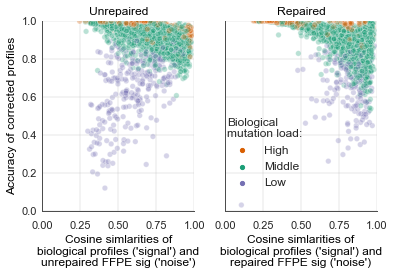

In [12]:
## overall correction accuracy
sns.set(style="whitegrid", color_codes=True, rc={"grid.linewidth": 0.3, 'grid.color': '.7', 
                                                 'ytick.major.size': 2,'axes.edgecolor': '.3', 
                                                 'axes.linewidth': 1})
f, (ax1, ax2) = plt.subplots(1,2, figsize=(6, 3.5), sharey = True, sharex =True)

sns.scatterplot(x = "Similarity_FFPEsig_original", y = "Correction_accuracy", 
                hue = "mutationload_label", palette = "Dark2",
                data = unrepaired_stat,  alpha = 0.3, s = 30, ax = ax1)

handles, labels = ax1.get_legend_handles_labels()

ax1.set_xlim(0,1)
ax1.set_ylim(0,1)
ax1.legend ('', frameon = False)
ax1.set_xlabel("Cosine simlarities of\nbiological profiles ('signal') and\nunrepaired FFPE sig ('noise')", 
           size = 12, color = "black")
ax1.set_ylabel("Accuracy of corrected profiles", size = 12, color = "black")
ax1.set_title ("Unrepaired", color = "black", size = 12)


sns.scatterplot(x = "Similarity_FFPEsig_original", y = "Correction_accuracy", 
                hue = "mutationload_label", palette = "Dark2",
                data = repaired_stat,  alpha = 0.3, s = 30, ax = ax2, legend = None )

ax2.legend([handles[2], handles[1], handles[3]],
           [labels[2], labels[1], labels[3]], 
           bbox_to_anchor=(0.58, 0.55), 
           frameon = False, title = "Biological\nmutation load:", 
           fontsize = 12, markerscale = 0.7, ncol = 1)

ax2.set_xlim(0,1)
ax2.set_ylim(0,1)
sns.despine()
ax2.set_xlabel ("Cosine simlarities of\nbiological profiles ('signal') and\nrepaired FFPE sig ('noise')",
                size = 12, color = "black")
ax2.set_title ("Repaired", color = "black", size = 12)
#plt.savefig("./Figures/Fig2b.pdf", bbox_inches = "tight", dpi = 300)
plt.show()

In [13]:
unrepaired_mean = np.mean(unrepaired_stat['Correction_accuracy'])
unrepaired_CI = np.around(CI(unrepaired_stat['Correction_accuracy']),3)
print ("Unrepaired FFPE correction")
print (f'Mean:{unrepaired_mean:.3f}, 95% CI:{unrepaired_CI}')

repaired_mean = np.mean(repaired_stat['Correction_accuracy'])
repaired_CI = np.around(CI(repaired_stat['Correction_accuracy']),3)
print ("Repaired FFPE correction")
print (f'Mean:{repaired_mean:.3f}, 95% CI:{repaired_CI}')

Unrepaired FFPE correction
Mean:0.891, 95% CI:[0.887 0.895]
Repaired FFPE correction
Mean:0.893, 95% CI:[0.889 0.897]


 ## 2.3 Possible factors affecting the noise correction accuracy

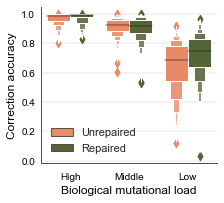

In [14]:
unrepaired_stat['label'] = "Unrepaired"
repaired_stat['label'] = "Repaired"
combined_stat = pd.concat((unrepaired_stat,repaired_stat))

sns.set(style="whitegrid", color_codes=True, rc={"grid.linewidth": 0.3, 'grid.color': '.7', 
                                                 'ytick.major.size': 2,'axes.edgecolor': '.3', 
                                                 'axes.linewidth': 1})
#ax.set(yscale="log")
sns.catplot(x = 'mutationload_label', y = 'Correction_accuracy', kind = 'boxen', hue = "label",legend= None,
            data = combined_stat,height = 3, aspect = 1.1,
            order = ['High', 'Middle', 'Low'],palette=['coral','darkolivegreen'])
plt.ylabel ("Correction accuracy",  size = 12, color = "black") 
plt.xlabel("Biological mutational load",size = 12, color = "black")
plt.xticks (size = 10, color = "black")
plt.yticks (size = 10, color = "black")
plt.legend(loc = "lower left",frameon = False)
plt.savefig("./Figures/Fig2d.pdf", bbox_inches = "tight", dpi = 300)
plt.show()

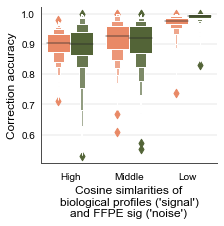

In [15]:
sns.set(style="whitegrid", color_codes=True, rc={"grid.linewidth": 0.3, 'grid.color': '.7', 
                                                 'ytick.major.size': 2,'axes.edgecolor': '.3',
                                                 'axes.linewidth': 1})
df_tmp = combined_stat.loc[list(combined_stat.mutationload_label.values !="Low"),:]
sns.catplot(x = 'similarity_label', y = 'Correction_accuracy', kind = 'boxen', hue = "label",legend= None,
            data = df_tmp, height = 3, aspect = 1.1,
            order = ['High', 'Middle', 'Low'],palette=['coral','darkolivegreen'])
plt.ylabel ("Correction accuracy",  size = 12, color = "black")
plt.xlabel("Cosine simlarities of\nbiological profiles ('signal')\nand FFPE sig ('noise')", 
           size = 12, color = "black")
plt.xticks (size = 10, color = "black")
plt.yticks (size = 10, color = "black")
plt.savefig("./Figures/Fig2d.pdf", bbox_inches = "tight", dpi = 300)
plt.show()

## 2.4 Correction accuracy grouped by main cancer types

In [16]:
## main cancer types include more than 20 samples within the cancer type:
cancer_types_count = unrepaired_stat.groupby('Cancer_type')['Samples'].count()
main_cancer_types = cancer_types_count.index[cancer_types_count > 20]

unrepaired_stat_filtered = unrepaired_stat.loc[[ctype in main_cancer_types for 
                                                ctype in unrepaired_stat.Cancer_type],:].copy()

repaired_stat_filtered = repaired_stat.loc[[ctype in main_cancer_types for 
                                                ctype in repaired_stat.Cancer_type],:].copy()

## combine unrepaired and repaired FFPE data together
repaired_stat_filtered['label'] = "Repaired"
unrepaired_stat_filtered['label'] = "Unrepaired"
combined_stat_mainCancerTypes = pd.concat((unrepaired_stat_filtered, repaired_stat_filtered))
combined_stat_mainCancerTypes.head(2)

,Samples,Cancer_type,Correction_accuracy,Similarity_FFPEsig_original,mutationload_label,similarity_label,label
0,Biliary-AdenoCA::SP117655,Biliary-AdenoCA,0.958161,0.808912,Middle,Middle,Unrepaired
1,Biliary-AdenoCA::SP117556,Biliary-AdenoCA,0.939867,0.577183,Middle,Middle,Unrepaired


### 2.4.1 Sorted cancer types based on overall mean accuracy

In [17]:
combined_stat_mainCancerTypes['MutationLoad'] = [profile_values[sample][C2T_ind].sum() 
                                                 for sample in combined_stat_mainCancerTypes['Samples'].values]
combined_stat_mainCancerTypes.groupby ('Cancer_type').mean().sort_values(by="Correction_accuracy")

,Correction_accuracy,Similarity_FFPEsig_original,MutationLoad
Cancer_type,,,
CNS-PiloAstro,0.610381,0.689064,112.157303
Thy-AdenoCA,0.804901,0.747765,543.604167
Myeloid-MPN,0.820206,0.754573,573.607143
CNS-Medullo,0.820772,0.735463,602.226027
Panc-Endocrine,0.844248,0.763406,952.294118
Kidney-ChRCC,0.859426,0.745546,1289.133333
Lymph-CLL,0.862667,0.788714,761.831579
Prost-AdenoCA,0.878563,0.756379,1288.506993
Stomach-AdenoCA,0.882075,0.761679,7394.813333


### 2.4.2 Mean accuracy for repaired and unrepaired FFPEs for each cancer type

In [18]:
combined_stat_mainCancerTypes.groupby (by=[ "label",'Cancer_type']).mean()

Correction_accuracy  Similarity_FFPEsig_original  \
label      Cancer_type                                                          
Repaired   Biliary-AdenoCA              0.917996                     0.724266   
           Bladder-TCC                  0.969315                     0.480762   
           Bone-Osteosarc               0.907757                     0.680391   
           Breast-AdenoCA               0.905529                     0.709154   
           CNS-GBM                      0.941376                     0.898029   
           CNS-Medullo                  0.812388                     0.923873   
           CNS-PiloAstro                0.698641                     0.882003   
           ColoRect-AdenoCA             0.935775                     0.888935   
           Eso-AdenoCA                  0.888537                     0.833313   
           Head-SCC                     0.922163                     0.626076   
           Kidney-ChRCC                 0.828891                     0.886389   
           Kidney-RCC                   0.939367                     0.646504   
           Liver-HCC                    0.970967                     0.571314   
           Lung-AdenoCA                 0.936729                     0.594303   
           Lung-SCC                     0.980979                     0.479889   
           Lymph-BNHL                   0.893500                     0.805457   
           Lymph-CLL                    0.846016                     0.833721   
           Myeloid-MPN                  0.809005                     0.816147   
           Ovary-AdenoCA                0.906398                     0.758766   
           Panc-AdenoCA                 0.901836                     0.900069   
           Panc-Endocrine               0.857493                     0.687465   
           Prost-AdenoCA                0.848423                     0.904055   
           Skin-Melanoma                0.983956                     0.387249   
           Stomach-AdenoCA              0.873289                     0.846603   
           Thy-AdenoCA                  0.813907                     0.733755   
           Uterus-AdenoCA               0.920361                     0.775985   
Unrepaired Biliary-AdenoCA              0.924295                     0.793172   
           Bladder-TCC                  0.971335                     0.742468   
           Bone-Osteosarc               0.875745                     0.861320   
           Breast-AdenoCA               0.927729                     0.763780   
           CNS-GBM                      0.974614                     0.438069   
           CNS-Medullo                  0.829156                     0.547054   
           CNS-PiloAstro                0.522122                     0.496126   
           ColoRect-AdenoCA             0.968427                     0.485122   
           Eso-AdenoCA                  0.921870                     0.728906   
           Head-SCC                     0.940682                     0.767921   
           Kidney-ChRCC                 0.889961                     0.604703   
           Kidney-RCC                   0.861504                     0.915235   
           Liver-HCC                    0.896969                     0.930400   
           Lung-AdenoCA                 0.932209                     0.827941   
           Lung-SCC                     0.935255                     0.916348   
           Lymph-BNHL                   0.893151                     0.788297   
           Lymph-CLL                    0.879317                     0.743707   
           Myeloid-MPN                  0.831408                     0.692999   
           Ovary-AdenoCA                0.886405                     0.831826   
           Panc-AdenoCA                 0.952150                     0.591624   
           Panc-Endocrine               0.831003                     0.839346   
           Prost-AdenoCA                0.908703            

### 2.4.3 Well-correction samples (accuracy > 0.9)

In [19]:
## Compute the percentage of well reconstructed samples in each type 
def collect_well_reconstructed_ratio (df):
    ratios = []
    types = []
    cutoff = 0.9
    for ctype in df["Cancer_type"].unique():
        passed = sum(df.loc[df.Cancer_type == ctype, "Correction_accuracy"] >= cutoff)
        total = sum(df.Cancer_type == ctype)
        ratio = passed/total
        ratios.append(ratio)
        types.append(ctype)
    ratio_df = pd.DataFrame({'Cancer_type':types, 'ratios': ratios})
    ratio_df = ratio_df.sort_values(by=['ratios'], ascending = False)
    return (ratio_df)

unrepaired_ratio_df = collect_well_reconstructed_ratio(df = unrepaired_stat_filtered.copy())
repaired_ratio_df = collect_well_reconstructed_ratio(df = repaired_stat_filtered.copy())

well_constructed_df = unrepaired_ratio_df.merge(repaired_ratio_df,on = 'Cancer_type', suffixes = ("_unrepaired",
                                                                                                  "_repaired"))
well_constructed_df_sorted = well_constructed_df.sort_values('ratios_unrepaired', ascending = False)

p_values = []
for ct in well_constructed_df_sorted.Cancer_type:
    x1 = unrepaired_stat_filtered.loc[unrepaired_stat_filtered.Cancer_type == ct,
                                 :]['Correction_accuracy'].values
    x2 = repaired_stat_filtered.loc[repaired_stat_filtered.Cancer_type == ct,
                                 :]['Correction_accuracy'].values
    t, p = mannwhitneyu(x1, x2, alternative='two-sided')
    p_values.append(p)

well_constructed_df_sorted['p_value'] = p_values

p_labels = []
for p in well_constructed_df_sorted['p_value']:
    if p < 0.001:
        p_labels.append("***")
    elif p < 0.01 and p > 0.001:
        p_labels.append("**")
    elif p < 0.05 and p > 0.01:
        p_labels.append("*")
    else:
        p_labels.append("")
        
well_constructed_df_sorted['labels'] = p_labels

unrepaired_ratio_num = (well_constructed_df_sorted.ratios_unrepaired * 100 ).astype("int").values
repaired_ratio_num = (well_constructed_df_sorted.ratios_repaired * 100 ).astype("int").values

well_constructed_df_sorted

,Cancer_type,ratios_unrepaired,ratios_repaired,p_value,labels
0,CNS-GBM,1.000000,0.926829,1.453413e-07,***
1,ColoRect-AdenoCA,0.983333,0.750000,9.354066e-04,***
2,Skin-Melanoma,0.943925,0.962617,2.545433e-02,*
3,Uterus-AdenoCA,0.941176,0.647059,8.874570e-03,**
4,Panc-AdenoCA,0.917012,0.589212,5.297804e-29,***
5,Bladder-TCC,0.869565,0.913043,8.777798e-01,
6,Lung-AdenoCA,0.868421,0.763158,8.746152e-02,
7,Head-SCC,0.842105,0.736842,2.273902e-01,
8,Lung-SCC,0.833333,1.000000,2.526729e-11,***
9,Eso-AdenoCA,0.795918,0.408163,3.618516e-10,***


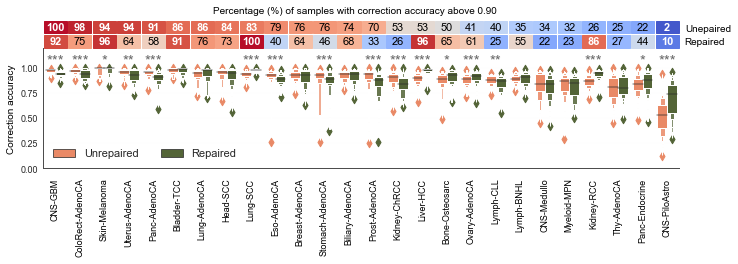

In [20]:
sns.set(style="whitegrid", color_codes=True, rc={"grid.linewidth": 0.01, 'grid.color': '.7', 
                                                 'ytick.major.size': 2, 'axes.edgecolor': '.3', 
                                                 'axes.linewidth': 1})

sns.catplot(x = 'Cancer_type', y = 'Correction_accuracy', palette=['coral','darkolivegreen'],
            data = combined_stat_mainCancerTypes, order = well_constructed_df_sorted.Cancer_type.values, 
            hue = "label",legend= None, kind = 'boxen', height = 2.5, aspect = 4,)
plt.xticks(rotation = 90, size = 9, color = "black")
plt.yticks( size = 9)

plt.xlabel ("")
plt.ylim(0, 1.2)
plt.legend(loc = "lower left", ncol = 2, frameon = False)
plt.ylabel ("Correction accuracy",  size = 10, color = "black")
cutoff = 0.9
Targeted_cancers = unrepaired_ratio_df.Cancer_type.values
length = len(Targeted_cancers)
for i in range(length):
    ## bottom pannel color bars 
    left, width = 0 + 1/length * i + 0.001, 1/length - 0.002        
    bottom, height = 1.12, 0.10
    right = left + width
    top = bottom + height
    ax = plt.gca()
    col_ind = unrepaired_ratio_num[i]
    colors =sns.color_palette("coolwarm", np.max(unrepaired_ratio_num) +1) 
    p = plt.Rectangle((left, bottom), width, height, fill=True, color = colors[col_ind])
    p.set_transform(ax.transAxes)
    p.set_clip_on(False)
    ax.add_patch(p)
    
    if col_ind > 20 and col_ind < 80:
        ax.text(0.5 * (left + right), 0.5 * (bottom + top), unrepaired_ratio_num[i], 
            color = "black", size = 11,
                horizontalalignment='center',verticalalignment='center', transform=ax.transAxes)
    else:
        ax.text(0.5 * (left + right), 0.5 * (bottom + top), unrepaired_ratio_num[i], 
            color = "w",weight = "bold", size = 11,
                horizontalalignment='center',verticalalignment='center', transform=ax.transAxes)
    
    ax.text(0.5 * (left + right), 0.38 * (bottom + top), well_constructed_df_sorted['labels'][i], 
            color = "dimgrey", size = 15,
                horizontalalignment='center',verticalalignment='center', transform=ax.transAxes)
    ## top pannel color bars
    left, width = 0 + 1/length * i + 0.001, 1/length - 0.002
        
    bottom, height = 1.003, 0.10
    right = left + width
    top = bottom + height
    ax = plt.gca()
    col_ind = repaired_ratio_num[i]
    colors =sns.color_palette("coolwarm", np.max(repaired_ratio_num) +1) 
    p = plt.Rectangle((left, bottom), width, height, fill=True, color = colors[col_ind])
    p.set_transform(ax.transAxes)
    p.set_clip_on(False)
    ax.add_patch(p)
    
    if col_ind > 20 and col_ind < 80:
        ax.text(0.5 * (left + right), 0.5 * (bottom + top), repaired_ratio_num[i], 
            color = "black", size = 11,
                horizontalalignment='center',verticalalignment='center', transform=ax.transAxes)
    else:
        ax.text(0.5 * (left + right), 0.5 * (bottom + top), repaired_ratio_num[i], 
            color = "w",weight = "bold", size = 11,
                horizontalalignment='center',verticalalignment='center', transform=ax.transAxes)
## top pannel annotation
ax.text(0.53*(left + right), 0.5 *(bottom + top), "Repaired", 
            color = "black", size = 10,
                horizontalalignment='center',verticalalignment='center', transform=ax.transAxes)   
## bottom pannel annotation
ax.text(0.533*(left + right), 0.55 *(bottom + top), "Unepaired", 
            color = "black", size = 10,
                horizontalalignment='center',verticalalignment='center', transform=ax.transAxes)
ax.text(0.25*(left + right), 0.62 *(bottom + top), 
        f"Percentage (%) of samples with correction accuracy above {cutoff:.2f}", 
        color = "black", size = 10,
        horizontalalignment='center',verticalalignment='center', transform=ax.transAxes)
plt.savefig("./Figures/Fig2c.pdf", bbox_inches = "tight", dpi = 300)
plt.show()

## 2.5 Correction accuracy with increasing FFPE noise load

### 2.5.1 Simulating data

In [21]:
## selecting cancer types with 80% of well-corrected samples for repaired and unrepaired FFPEs:

well_constructed_cancers = well_constructed_df.Cancer_type[[r1 > 0.8 and r2 > 0.8 
                                 for r1,r2 in zip (well_constructed_df.ratios_unrepaired, 
                                                   well_constructed_df.ratios_repaired)]].values

well_constructed_cancer_profiles = profile_values.loc[:,[t.split("::")[0] in well_constructed_cancers
                                                         for t in profile_values.columns]]
well_constructed_cancers, well_constructed_cancer_profiles.shape

(array(['CNS-GBM', 'Skin-Melanoma', 'Bladder-TCC', 'Lung-SCC'],
       dtype=object),
 (96, 219))

In [22]:
for level, load in zip([1,3,4,5],[10**3, 5*10**4, 10**5, 10**6]):
    simulated_df_unrepaired, simulated_df_repaired = pd.DataFrame(), pd.DataFrame()
    for i, col in enumerate(well_constructed_cancer_profiles.columns):
        npr.seed(i + 1)
        sample = well_constructed_cancer_profiles[col].to_numpy()
        simulated_df_unrepaired [col] = simulation(sample_indvidual = sample, 
                                                    ffpe_sig = ffpe_sig_unrepaired, 
                                                    ffpe_load = load)
    
        simulated_df_repaired [col] = simulation(sample_indvidual = sample, 
                                                    ffpe_sig = ffpe_sig_repaired, 
                                                    ffpe_load = load)
    ## write the simulated samples to Data folder
    simulated_df_unrepaired.to_csv ("./Data/Different_FFPEloads/simulated_PCAWG_FFPE_unrepaired_L" + 
                                    str(level) + ".csv", index = False)
    simulated_df_repaired.to_csv ("./Data/Different_FFPEloads/simulated_PCAWG_FFPE_repaired_L" + 
                                    str(level) + ".csv", index = False)

In [23]:
## signal-to-noise ratio under 10^6 noise
np.median(well_constructed_cancer_profiles.loc[C2T_ind,:].sum() / 1000000)

0.008836

### 2.5.2 Read the corrected results

The correction on noise-changed samples is performed on local HPC cluster as well.

In [24]:
cancer_list, sample_list, accuracy_list, level_list, ffpe_load_list, label_list = [], [], [], [], [], []

path = "./Data/Different_FFPEloads/"

for label in ['unrepaired', 'repaired']:
    for level, ffpe_load in zip(['L1','L2','L3','L4','L5'],[10**3, 10**4, 5*10**4, 10**5, 10**6]): 
        corrected_profiles_DiffLevel = pd.read_csv(path + label + "_profiles_corrected_" + level +".csv",
                                          sep = "\t")

        cancer = [col.split("::")[0] for col in corrected_profiles_DiffLevel.columns[1:]]
        cancer_list += cancer

        sample = [col.split("::")[1] for col in corrected_profiles_DiffLevel.columns[1:]]
        sample_list += sample
        n_channel = np.sum(C2T_ind)
        accuracy_correction = [cosine_similarity(profile_values[col][C2T_ind].to_numpy().reshape(1,n_channel), 
                                corrected_profiles_DiffLevel[col][C2T_ind].to_numpy().reshape(1,n_channel))[0][0] 
                               for col in corrected_profiles_DiffLevel.columns[1:]]
        accuracy_list += accuracy_correction

        level_list += [level] * len(accuracy_correction)
        ffpe_load_list += [ffpe_load] * len(accuracy_correction)
        label_list += [label] * len(accuracy_correction)

## making dataframe using the collected data        
correction_stats_DiffLevel = pd.DataFrame({'Cancer_type' : cancer_list,
                                         'Sample' : sample_list,
                                         'Accuracy' : accuracy_list,
                                         'Noise_level' : level_list,
                                         'FFPE_load' : ffpe_load_list,
                                         'Label' : label_list})
correction_stats_DiffLevel.head(2)

,Cancer_type,Sample,Accuracy,Noise_level,FFPE_load,Label
0,Bladder-TCC,SP1086,0.961940,L1,1000,unrepaired
1,Bladder-TCC,SP1003,0.994193,L1,1000,unrepaired


## 2.6 Getting the mean correction accuracy over different noise levels

In [25]:
correction_stats_DiffLevel.groupby(['Label', 'Noise_level'])['Accuracy'].mean()

Label       Noise_level
repaired    L1             0.979199
            L2             0.973794
            L3             0.953039
            L4             0.940261
            L5             0.838469
unrepaired  L1             0.970679
            L2             0.969585
            L3             0.955554
            L4             0.944876
            L5             0.858575
Name: Accuracy, dtype: float64

In [26]:
correction_stats_DiffLevel.groupby(['Label', 'Noise_level'])['Accuracy'].apply(lambda x: CI(x))

Label       Noise_level
repaired    L1              (0.9756624600526129, 0.982736515525874)
            L2             (0.9692287818231393, 0.9783595621691077)
            L3             (0.9431724708764628, 0.9629062776132353)
            L4              (0.9276245142014552, 0.952896766072163)
            L5             (0.8085370992981799, 0.8683999474704648)
unrepaired  L1             (0.9655623026835115, 0.9757964715437765)
            L2             (0.9645432601938968, 0.9746258622986861)
            L3              (0.947996174621193, 0.9631128041288023)
            L4             (0.9356675672639271, 0.9540836368361881)
            L5             (0.8369054034214508, 0.8802439617373109)
Name: Accuracy, dtype: object

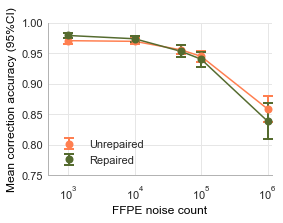

In [27]:
sns.set(style="whitegrid", color_codes=True, rc={"grid.linewidth": 1, 'grid.color': '.9', 
                                                 'ytick.major.size': 2,'axes.edgecolor': '.7',
                                                 'axes.linewidth': 1,'figure.figsize':(4,2.8)})
f, ax = plt.subplots()
ax.set(xscale="log")

noise_levels = [10**3, 10**4, 5*10**4, 10**5, 10**6]

## unrepaired
df_tmp = correction_stats_DiffLevel[correction_stats_DiffLevel['Label'] == "unrepaired"]

level_means = df_tmp.groupby('Noise_level').mean()['Accuracy']
level_lower_limits = df_tmp.groupby('Noise_level')['Accuracy'].apply(lambda x: CI(x)[0])
level_higher_limits = df_tmp.groupby('Noise_level')['Accuracy'].apply(lambda x: CI(x)[1])

plt.plot(noise_levels, level_means, color = "coral")
plt.errorbar(noise_levels, level_means, 
             yerr = [level_means - level_lower_limits, level_higher_limits - level_means], 
             fmt = "o", capsize=5, elinewidth = 2, markeredgewidth = 2,
             color = "coral", label = "Unrepaired")

## repaired
df_tmp = correction_stats_DiffLevel[correction_stats_DiffLevel['Label'] == "repaired"].copy()

level_means = df_tmp.groupby('Noise_level').mean()['Accuracy']
level_lower_limits = df_tmp.groupby('Noise_level')['Accuracy'].apply(lambda x: CI(x)[0])
level_higher_limits = df_tmp.groupby('Noise_level')['Accuracy'].apply(lambda x: CI(x)[1])

plt.plot(noise_levels, level_means, color = "darkolivegreen")
plt.errorbar(noise_levels, level_means, 
             yerr = [level_means - level_lower_limits, level_higher_limits - level_means], 
             fmt = "o", capsize=5, elinewidth=2, markeredgewidth=2,
             color = "darkolivegreen", label = "Repaired")

plt.xlim (500, 10**6 + 150000)
plt.ylim(0.75, 1)

plt.legend(loc = "lower left", frameon = False)
plt.xlabel ("FFPE noise count", size = 12, color = "black")
plt.ylabel("Mean correction accuracy (95%CI)",size = 12, color = "black")
sns.despine()
plt.savefig("./Figures/Fig2f.pdf", bbox_inches = "tight", dpi = 300)
plt.show()